### Running API for getting data set

In [1]:
# making parameters
# Currency and Time Frame
params = {
    "count": 3000,
    "granularity": 'H1'
}

In [2]:
# Calling the API
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import oandapyV20
import oandapyV20.endpoints.instruments as instruments
client = oandapyV20.API(access_token="3e0f7f10c6e7badcfabbf14ec0ea6e0f-f46e39153b94a3659e539e630ae9112a")

r = instruments.InstrumentsCandles(instrument="EUR_USD", params=params)
db = client.request(r)
print(r.response)


{'instrument': 'EUR_USD', 'granularity': 'H1', 'candles': [{'complete': True, 'volume': 834, 'time': '2020-01-20T20:00:00.000000000Z', 'mid': {'o': '1.10918', 'h': '1.10980', 'l': '1.10915', 'c': '1.10977'}}, {'complete': True, 'volume': 274, 'time': '2020-01-20T21:00:00.000000000Z', 'mid': {'o': '1.10976', 'h': '1.10978', 'l': '1.10950', 'c': '1.10950'}}, {'complete': True, 'volume': 67, 'time': '2020-01-20T22:00:00.000000000Z', 'mid': {'o': '1.10945', 'h': '1.10980', 'l': '1.10945', 'c': '1.10972'}}, {'complete': True, 'volume': 238, 'time': '2020-01-20T23:00:00.000000000Z', 'mid': {'o': '1.10970', 'h': '1.10970', 'l': '1.10937', 'c': '1.10964'}}, {'complete': True, 'volume': 578, 'time': '2020-01-21T00:00:00.000000000Z', 'mid': {'o': '1.10962', 'h': '1.10969', 'l': '1.10910', 'c': '1.10924'}}, {'complete': True, 'volume': 1175, 'time': '2020-01-21T01:00:00.000000000Z', 'mid': {'o': '1.10926', 'h': '1.10931', 'l': '1.10888', 'c': '1.10906'}}, {'complete': True, 'volume': 788, 'time':

In [3]:
datetime.now()

datetime.datetime(2020, 7, 13, 22, 6, 21, 230016)

In [4]:
# Making DB from JSON
data_mid = pd.DataFrame(columns=('Time','Open','High','Low','Close','Vol'))

item={}
for i in range(len(db['candles'])):
    item={}
    item['Time']=db['candles'][i]['time']
    item['Open']=db['candles'][i]['mid']['o']
    item['High']=db['candles'][i]['mid']['h']
    item['Low']=db['candles'][i]['mid']['l']
    item['Close']=db['candles'][i]['mid']['c']
    item['Vol']=db['candles'][i]['volume']
    data_mid.loc[len(data_mid)]=item
  
data_mid['Date'] = pd.to_datetime(data_mid.Time)


data = data_mid.copy()
data.set_index('Date', inplace=True)
data['Open']=data.Open.astype(float)
data['High']=data.High.astype(float)
data['Low']=data.Low.astype(float)
data['Close']=(data.High+data.Low)/2
data['Vol']=data.Vol.astype(float)
data['Dev']=data.High-data.Low
data['M5']=data.Close.rolling(5).mean()
data['M20']=data.Close.rolling(20).mean()
data['M60']=data.Close.rolling(60).mean()
   

#### Making function
H_Periods: number of hours for making hurdle   
H_Bars : number of hurdles. Default = 10

In [5]:
def drawthechart(period=600,bars=10,drawing_period=600):

    #making base
    df = data.copy()
    df["High"] = df.High.rolling(period).max()
    df["Low"] = df.Low.rolling(period).min()
    df["Price_Level"] = (df.High - df.Low)/bars
    
    temp_level_list = []
    temp_vol_list = []
    temp_rat_list = []

    for i in range(bars):
        temp_level = 'Level_' + str(i)
        temp_vol = 'Vol_'+str(i)
        temp_rat = 'Rat_'+str(i)
        df[temp_level] = df.Low + df.Price_Level*i
        df[temp_vol]=0
        df[temp_rat]=0
        temp_level_list.append(temp_level)
        temp_vol_list.append(temp_vol)
        temp_rat_list.append(temp_rat)
    df['Level_H']=df.High+0.00000001

    #print(df)
    
    # Making Mean values based on normal datafram use.
    db=df.copy()
    total_len = len(db)
    
    read_level_list = temp_level_list.copy() # Making list to read
    read_level_list.append('Level_H') # Original list does not have 'Level_H', adding now
    
    
    empty_df = pd.DataFrame()

    for i in range(total_len):
        loop_time = period
        if i > period :
            index_from  = db.index[i-period+1]
            index_to = db.index[i] # Present day
            index_to_2 = db.index[i-1] # To avoid double counting the present day
    
            mid_db = db.loc[[index_to],:].copy()
            add_db = db.loc[index_from:index_to_2,['Close','Vol']]
            result = pd.concat([mid_db,add_db], sort=False)
            # Fill NA values from the present day
            result = result.fillna(method='ffill')
            
            #calculate
            col_num = bars
            row_num = 1
            result_index_list = result.index.tolist()
    
            temp_vol_sum = 0 # sum of volume for calculate the ratio
            for j in range(len(temp_vol_list)):
                insert_vol = temp_vol_list[j]
                read_lev = read_level_list[j]
                read_lev_1 = read_level_list[j+1]
                result[insert_vol].loc[(result.Close >= result[read_lev])&(result.Close < result[read_lev_1])] = result.Vol
                temp_vol_sum = result.Vol.sum() # Total Volumn of result table
                
                insert_rat = temp_rat_list[j]
                result.loc[index_to, insert_rat] = (result[insert_vol].sum()/temp_vol_sum)*100
            adding_block = result.loc[[index_to],:].copy()    
            empty_df = pd.concat([empty_df,adding_block], sort=False)
    #print(empty_df)
    
    final = empty_df.copy()
    final = final.fillna(0)
        
    s = final.filter(like='Rat_').idxmax(1).str.replace('Rat_','Level_')
    final['Show_L'] = final.lookup(s.index,s)
    final['Show_H'] = final.Show_L + final.Price_Level
    
    drawing_period = drawing_period*(-1)
    drawing = final.iloc[drawing_period:,:]
    plt.figure(figsize=(25,15))
    top = plt.subplot2grid((4,4),(0,0), rowspan=3, colspan=4)
    picture = drawing.loc[:,['Close','Show_L','Show_H','M5']]
    top.plot(picture.index, picture[['Close','Show_L','Show_H','M5']])
    print(picture.tail())
    return


C:\Users\bearp\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\bearp\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


                              Close    Show_L    Show_H        M5
Date                                                             
2020-07-13 16:00:00+00:00  1.136620  1.120972  1.125104  1.135270
2020-07-13 17:00:00+00:00  1.136995  1.120972  1.125104  1.136048
2020-07-13 18:00:00+00:00  1.136085  1.120972  1.125104  1.136434
2020-07-13 19:00:00+00:00  1.135025  1.120972  1.125104  1.136214
2020-07-13 20:00:00+00:00  1.134710  1.120972  1.125104  1.135887


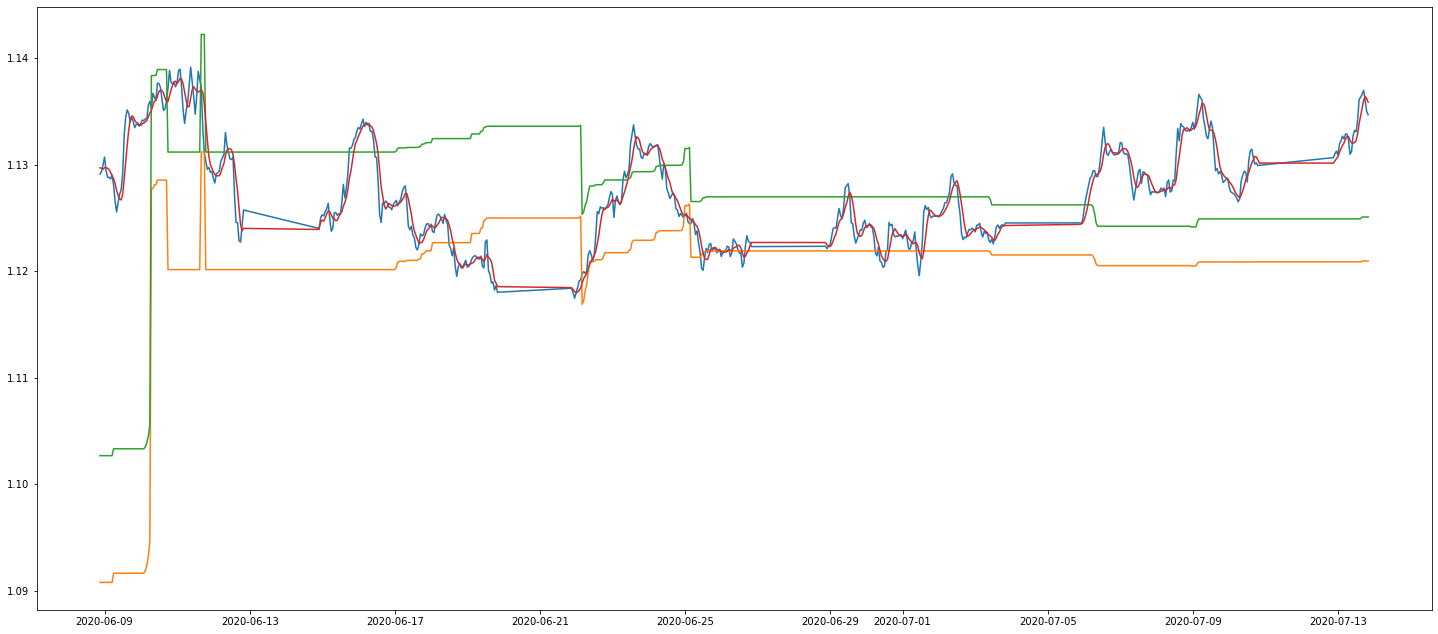

In [6]:
drawthechart(period=400,bars=5,drawing_period=600)

                              Close    Show_L    Show_H        M5
Date                                                             
2020-07-13 16:00:00+00:00  1.136620  1.120972  1.123038  1.135270
2020-07-13 17:00:00+00:00  1.136995  1.120972  1.123038  1.136048
2020-07-13 18:00:00+00:00  1.136085  1.120972  1.123038  1.136434
2020-07-13 19:00:00+00:00  1.135025  1.120972  1.123038  1.136214
2020-07-13 20:00:00+00:00  1.134710  1.120972  1.123038  1.135887


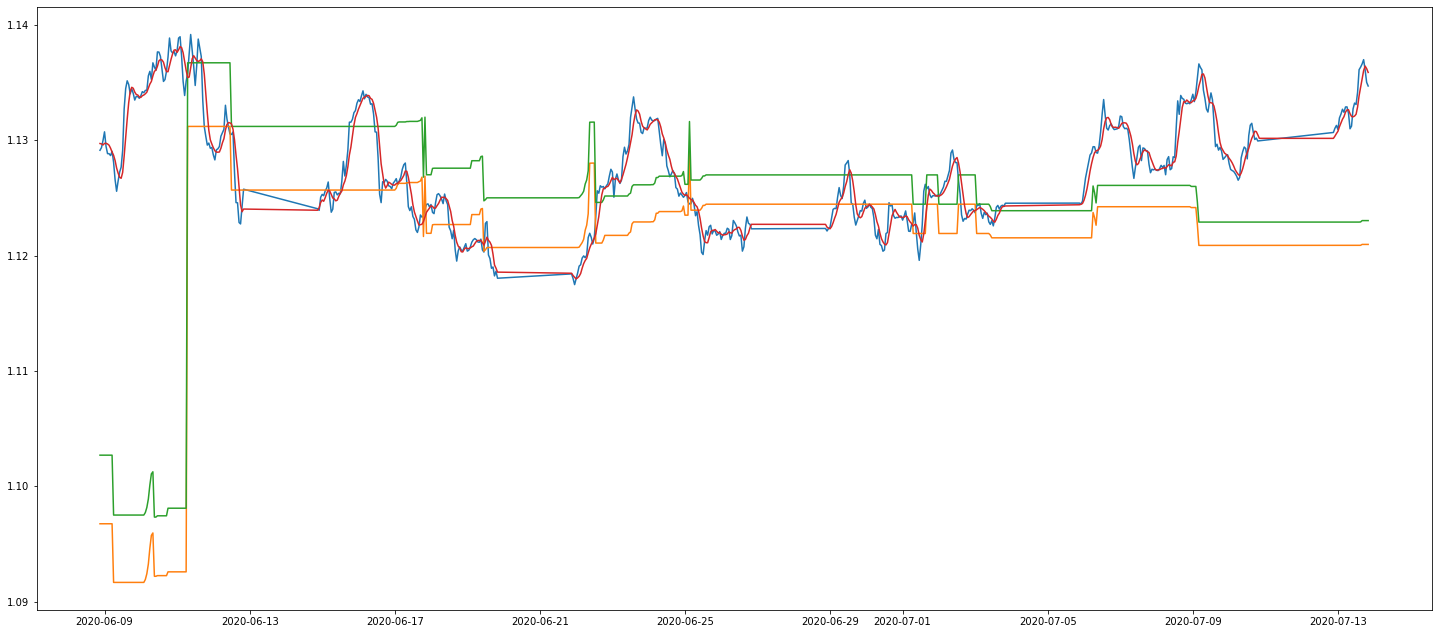

In [7]:
drawthechart(period=400,bars=10,drawing_period=600)

                              Close   Show_L  Show_H        M5
Date                                                          
2020-07-13 16:00:00+00:00  1.136620  1.12192   1.127  1.135270
2020-07-13 17:00:00+00:00  1.136995  1.12192   1.127  1.136048
2020-07-13 18:00:00+00:00  1.136085  1.12192   1.127  1.136434
2020-07-13 19:00:00+00:00  1.135025  1.12192   1.127  1.136214
2020-07-13 20:00:00+00:00  1.134710  1.12192   1.127  1.135887


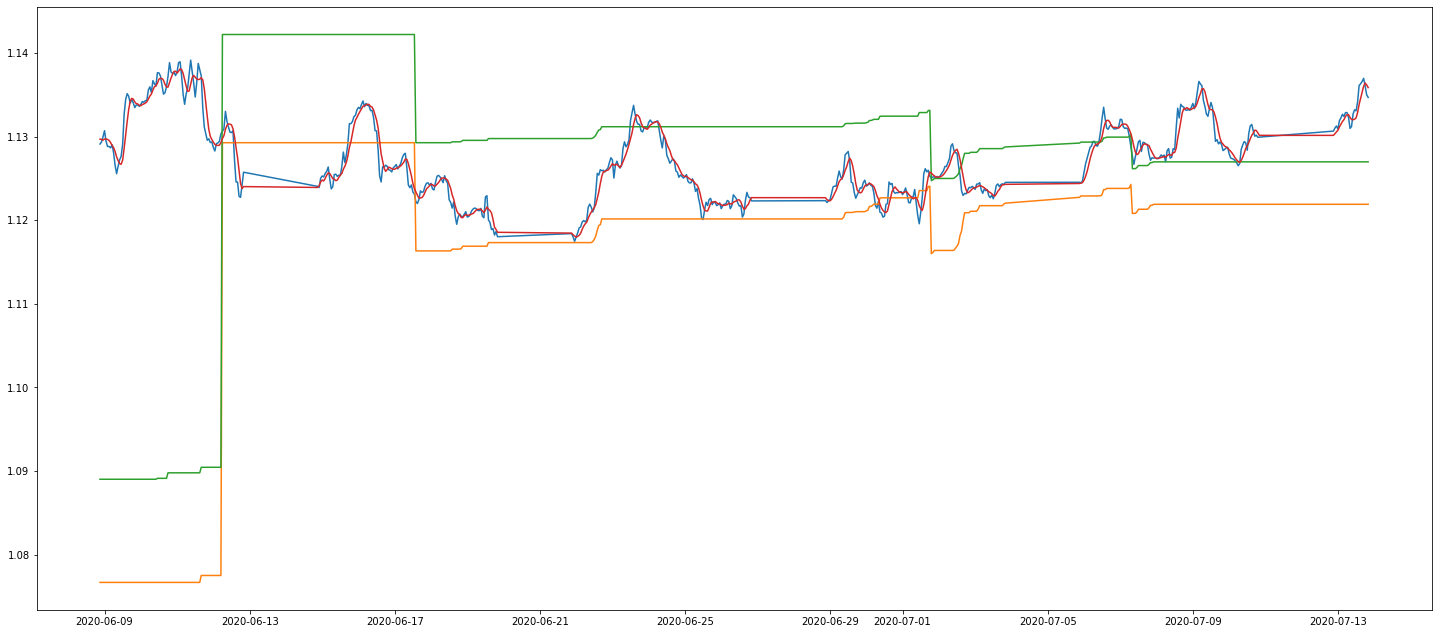

In [8]:
drawthechart(period=600,bars=5,drawing_period=600)

                              Close   Show_L   Show_H        M5
Date                                                           
2020-07-13 16:00:00+00:00  1.136620  1.12192  1.12446  1.135270
2020-07-13 17:00:00+00:00  1.136995  1.12192  1.12446  1.136048
2020-07-13 18:00:00+00:00  1.136085  1.12192  1.12446  1.136434
2020-07-13 19:00:00+00:00  1.135025  1.12192  1.12446  1.136214
2020-07-13 20:00:00+00:00  1.134710  1.12192  1.12446  1.135887


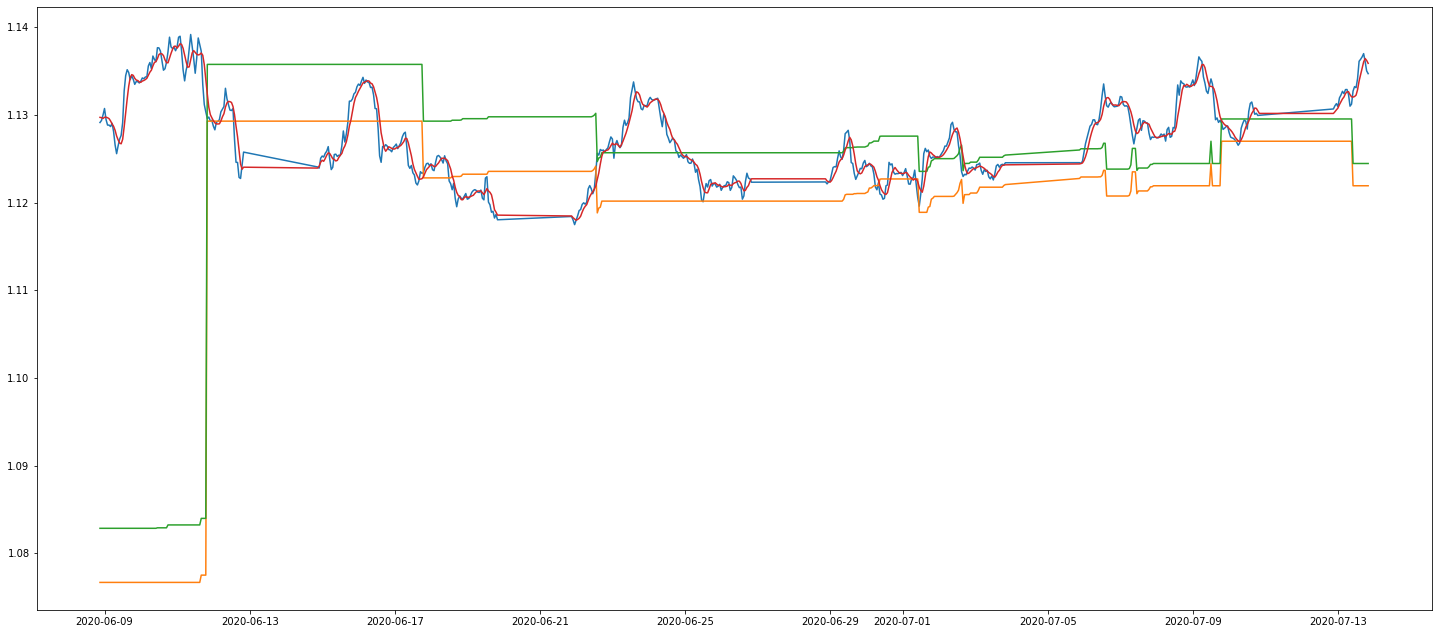

In [9]:
drawthechart(period=600,bars=10,drawing_period=600)

In [10]:
s = final.filter(like='Rat_').idxmax(2).str.replace('Rat_','Level_')
final['Show_L_2'] = final.lookup(s.index,s)
final['Show_H_2'] = final.Show_L + final.Price_Level

NameError: name 'final' is not defined

In [ ]:
drawing_period = period*-1
drawing = final.iloc[drawing_period:,:]

#drawing = final.iloc[-10:,:]
#drawing
plt.figure(figsize=(25,10))
top = plt.subplot2grid((4,4),(0,0), rowspan=3, colspan=4)
picture = drawing.loc[:,['Close','Show_L','Show_H','M5']]
top.plot(picture.index, picture[['Close','Show_L','Show_H','M5']])

In [ ]:
drawing.tail()

In [ ]:
def running(period, win):
    first_step(win)
    calculating(period, bars=10)
    